<a href="https://colab.research.google.com/github/satyam-jyoti-sankar/Books_recommend_system/blob/main/Books_recommend_system_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## During the last few decades, with the rise of Youtube, Amazon, Netflix, and many other such web services, recommender systems have taken more and more place in our lives. 

From e-commerce (suggest to buyers articles that could interest them) to online advertisement

(suggest to users the right contents, matching their preferences), recommender systems are today unavoidable in our daily online journeys.

In a very general way, recommender systems are algorithms aimed at suggesting relevant items to users (items being movies to watch, text to read, products to buy, or anything else
depending on industries).

Recommender systems are really critical in some industries as they can generate a huge
amount of income when they are efficient or also be a way to stand out significantly from
competitors.

 The main objective is to create a book recommendation system for users.
## Content

The Book-Crossing dataset comprises 3 files.

● Users
Contains the users. Note that user IDs (User-ID) have been anonymized and map to
integers. Demographic data is provided (Location, Age) if available. Otherwise, these
fields contain NULL values.

● Books
Books are identified by their respective ISBN. Invalid ISBNs have already been removed
from the dataset. Moreover, some content-based information is given (Book-Title,
Book-Author, Year-Of-Publication, Publisher), obtained from Amazon Web
Services. Note that in the case of several authors, only the first is provided. URLs linking
to cover images are also given, appearing in three different flavors (Image-URL-S,
Image-URL-M, Image-URL-L), i.e., small, medium, large. These URLs point to the
Amazon website.

● Ratings
Contains the book rating information. Ratings (Book-Rating) are either explicit,
expressed on a scale from 1-10 (higher values denoting higher appreciation), or implicit,expressed by 0 .


In [1]:
import re
import pickle
import operator
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from scipy.sparse import csr_matrix
from pandas.api.types import is_numeric_dtype
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings("ignore")

# Datasets

In [2]:
books = pd.read_csv(r"/content/drive/MyDrive/capstone_project-4/Recommend books/ data/Books.csv", error_bad_lines=False, encoding='ISO-8859-1') 
users = pd.read_csv(r"/content/drive/MyDrive/capstone_project-4/Recommend books/ data/Users.csv", error_bad_lines=False, encoding='ISO-8859-1') 
ratings = pd.read_csv(r"/content/drive/MyDrive/capstone_project-4/Recommend books/ data/Ratings.csv", error_bad_lines=False, encoding='ISO-8859-1') 

print("Books Data:    ", books.shape)
print("Users Data:    ", users.shape)
print("Books-ratings: ", ratings.shape)

Books Data:     (271360, 8)
Users Data:     (278858, 3)
Books-ratings:  (1149780, 3)


**Here we have 3  dataset one is details about book anathor is user of books data then howmuch the users are given the rating .**



**error_bad_lines=False** we ake if any line not read by the pandas just ignore it.


In [3]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [4]:
print("Columns: ", list(books.columns))
books.head()

Columns:  ['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher', 'Image-URL-S', 'Image-URL-M', 'Image-URL-L']


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [5]:
print("Columns: ", list(users.columns))
users.head()

Columns:  ['User-ID', 'Location', 'Age']


,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [6]:
print("Columns: ", list(ratings.columns))
ratings.head()

Columns:  ['User-ID', 'ISBN', 'Book-Rating']


,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


# Data Pre-processing

## Books Dataset Pre-processing

In [7]:
books.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], axis=1, inplace=True)
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


**Here we drop those column which contain url of book image because we work on book recommendation no need image and its urls. So we drop 3 columns  which contain image urls.**

In [8]:
 ## Checking for null values
books.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
dtype: int64

In [9]:
books[books['Book-Author'].isnull()]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
187689,9627982032,The Credit Suisse Guide to Managing Your Perso...,NaN,1995,Edinburgh Financial Publishing


In [10]:
books[books['Publisher'].isnull()]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN


In [11]:
books['ISBN']=books['ISBN'].apply(lambda x:x.upper())

**Without removing nan valu we take nan valu as other catagory**

In [12]:
books.at[187689 ,'Book-Author'] = 'Other'

books.at[128890 ,'Publisher'] = 'Other'
books.at[129037 ,'Publisher'] = 'Other'
# at those index valu where nan valu present we convert it as other

In [13]:
books['Year-Of-Publication'].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

**The publication must be int format but there are some error in it at some phase  it show 
 yr='DK Publishing Inc', yr='Gallimard'  its not posible**

In [14]:
books[(books['Year-Of-Publication']=='DK Publishing Inc') | (books['Year-Of-Publication']=='Gallimard')]
#here book author replace with yr and publiser replace with  imae link so we have to corect it or remove it

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...


In [15]:
books.at[209538 ,'Publisher'] = 'DK Publishing Inc'
books.at[209538 ,'Year-Of-Publication'] = 2000
books.at[209538 ,'Book-Title'] = 'DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)'
books.at[209538 ,'Book-Author'] = 'Michael Teitelbaum'

books.at[221678 ,'Publisher'] = 'DK Publishing Inc'
books.at[221678 ,'Year-Of-Publication'] = 2000
books.at[209538 ,'Book-Title'] = 'DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)'
books.at[209538 ,'Book-Author'] = 'James Buckley'

books.at[220731 ,'Publisher'] = 'Gallimard'
books.at[220731 ,'Year-Of-Publication'] = '2003'
books.at[209538 ,'Book-Title'] = 'Peuple du ciel - Suivi de Les bergers '
books.at[209538 ,'Book-Author'] = 'Jean-Marie Gustave Le ClÃ?Â©zio'

All data  now in form of int so we convert it to int

In [16]:
books['Year-Of-Publication']=books['Year-Of-Publication'].astype(int)

In [17]:
np.array(sorted(books['Year-Of-Publication'].unique()))

array([   0, 1376, 1378, 1806, 1897, 1900, 1901, 1902, 1904, 1906, 1908,
       1909, 1910, 1911, 1914, 1917, 1919, 1920, 1921, 1922, 1923, 1924,
       1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935,
       1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946,
       1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957,
       1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968,
       1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979,
       1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
       1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2008, 2010, 2011, 2012, 2020, 2021,
       2024, 2026, 2030, 2037, 2038, 2050])

**Here we se there are some yr which is more than current yr and some are 0 so we have to change it**

In [18]:
books[books['Year-Of-Publication']>2022]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
37487,0671746103,MY TEACHER FRIED MY BRAINS (RACK SIZE) (MY TEA...,Coville,2030,Aladdin
55676,0671791990,MY TEACHER FLUNKED THE PLANET (RACK SIZE) (MY ...,Bruce Coville,2030,Aladdin
78168,0870449842,Crossing America,National Geographic Society,2030,National Geographic
80264,0140301690,Alice's Adventures in Wonderland and Through t...,Lewis Carroll,2050,Puffin Books
97826,0140201092,Outline of European Architecture (Pelican S.),Nikolaus Pevsner,2050,Penguin USA
116053,0394701658,Three Plays of Eugene Oneill,Eugene O'Neill,2038,Vintage Books USA
118294,3442436893,Das groÃ?Ã?e BÃ?ÃÂ¶se- MÃ?ÃÂ¤dchen- Lese...,Kathy Lette,2026,Goldmann
192993,0870446924,"Field Guide to the Birds of North America, 3rd...",National Geographic Society,2030,National Geographic
228173,0671266500,FOREST PEOPLE (Touchstone Books (Hardcover)),Colin M. Turnbull,2030,Simon &amp; Schuster
240169,0684718022,In Our Time: Stories (Scribner Classic),Ernest Hemingway,2030,Collier Books


In [19]:
books['Year-Of-Publication'].describe([.80])

count    271360.000000
mean       1959.761273
std         257.992836
min           0.000000
50%        1995.000000
80%        2001.000000
max        2050.000000
Name: Year-Of-Publication, dtype: float64

In [20]:
# Replacing Invalid years with maximum time  year occ
books['Year-Of-Publication'].mode()

0    2002
dtype: int64

In [21]:
books.loc[books['Year-Of-Publication'] > 2022, 'Year-Of-Publication'] = 2002
books.loc[books['Year-Of-Publication'] == 0, 'Year-Of-Publication'] = 2002

**Yr can't be a flot so rather taken mean or median valu so we take invlid date to maximum occourance date(2002)**

In [22]:
books['Year-Of-Publication'].describe()

count    271360.000000
mean       1993.829769
std           8.319826
min        1376.000000
25%        1989.000000
50%        1996.000000
75%        2000.000000
max        2021.000000
Name: Year-Of-Publication, dtype: float64

In [23]:
## lowercasing all alphabets in ISBN
books['ISBN'] = books['ISBN'].str.lower()

In [24]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271360 non-null  object
 3   Year-Of-Publication  271360 non-null  int64 
 4   Publisher            271360 non-null  object
dtypes: int64(1), object(4)
memory usage: 10.4+ MB


In [25]:
## Drop duplicate rows
books.drop_duplicates(keep='last', inplace=True) 
books.reset_index(drop = True, inplace = True)

In [26]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271047 entries, 0 to 271046
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271047 non-null  object
 1   Book-Title           271047 non-null  object
 2   Book-Author          271047 non-null  object
 3   Year-Of-Publication  271047 non-null  int64 
 4   Publisher            271047 non-null  object
dtypes: int64(1), object(4)
memory usage: 10.3+ MB


In [27]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


## Users Dataset Pre-processing

In [28]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


**Here we see that the null valu present in age we try to correct it**

In [29]:
#Total null values
users.isnull().sum()

User-ID          0
Location         0
Age         110762
dtype: int64

**There are 11072 valu are null we can't remove  these many values so we try to cover it with mean age valu**

In [30]:
np.array(sorted(list(users['Age'].unique())))
#unique apply in users['age'] column (pandas) then convert the unique valu to array format


array([ nan,   0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,
        10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,
        21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,
        32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,
        43.,  44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,
        54.,  55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,
        65.,  66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,
        76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,
        87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,
        98.,  99., 100., 101., 102., 103., 104., 105., 106., 107., 108.,
       109., 110., 111., 113., 114., 115., 116., 118., 119., 123., 124.,
       127., 128., 132., 133., 136., 137., 138., 140., 141., 143., 146.,
       147., 148., 151., 152., 156., 157., 159., 162., 168., 172., 175.,
       183., 186., 189., 199., 200., 201., 204., 20

In [31]:
users.describe([.01,.80,.90,.95,.99])

,User-ID,Age
count,278858.00000,168096.000000
mean,139429.50000,34.751434
std,80499.51502,14.428097
min,1.00000,0.000000
1%,2789.57000,13.000000
50%,139429.50000,32.000000
80%,223086.60000,47.000000
90%,250972.30000,55.000000
95%,264915.15000,60.000000
99%,276069.43000,71.000000


**Here we se in our user data les than 1% data is bellow 13 yr but min age is 0 and almost 99% data cover on age of 71 but max age is 244.**

**So we consider the users age which is less than 10 and higher than 75 we consider it as outlayer .**

**We cap our outlayer with mean valu**


In [32]:
round(users['Age'].mean())

35

In [33]:
users.loc[users['Age'] > 75, 'Age'] = round(users['Age'].mean())    #outliers with age grater than 75 are substituted with mean 
users.loc[users['Age'] < 10, 'Age'] = round(users['Age'].mean())   #outliers with age less than 10 years are substitued with mean
users['Age'] = users['Age'].fillna(round(users['Age'].mean()))      #filling null values with mean
users['Age'] = users['Age'].astype(int)                               #changing Datatype to int

In [34]:
users.describe()

,User-ID,Age
count,278858.00000,278858.000000
mean,139429.50000,34.764489
std,80499.51502,10.300756
min,1.00000,10.000000
25%,69715.25000,29.000000
50%,139429.50000,35.000000
75%,209143.75000,35.000000
max,278858.00000,75.000000


In [35]:
len(users['Location'][1])

25

In [36]:
users['adress']=users['Location']

In [37]:
users['Location']=users['Location'].apply(lambda x: x.split(','))

**Location is devided into 3 catagory city,state ,country we separate those**

In [38]:
x=[]
for i in range(len(users['Location'])):
  if len(users['Location'][i])==3:
    continue
  elif len(users['Location'][i])<3:
    print(users['Location'][i])
    print(i)
  
  else:
     x.append(len(users['Location'][i]))
print(len(x))
np.unique(x)


['st. louis', ' missouri']
29419
['lawrenceville']
134376
1508


array([4, 5, 6, 7, 8, 9])

**Here we se country  is in fix position in the adress but the state and city position are not fixed  so we createonly country column.**

**For 2 where len(location) less than 3, there country prest in usa so we take those as usa as country name.**

In [39]:
users['Location'][29419].append('usa')
# users['Location'][29419]
users['Location'][134376].append('usa')

In [40]:
users['country']=users['Location'].apply(lambda x: x[-1].lower())
users.drop('Location',axis=1,inplace=True)

**Here we se country  is in fix position in the adress but the state and city position are not fixed  so we createonly country column.**

In [41]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   User-ID  278858 non-null  int64 
 1   Age      278858 non-null  int64 
 2   adress   278858 non-null  object
 3   country  278858 non-null  object
dtypes: int64(2), object(2)
memory usage: 8.5+ MB


##Ratings Dataset Pre-processing

In [42]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [43]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [44]:
ratings['ISBN']=ratings['ISBN'].apply(lambda x:x.upper())

In [45]:
## Drop duplicate rows
ratings.drop_duplicates(keep='last', inplace=True)
ratings.reset_index(drop=True, inplace=True)

In [46]:
ratings.info()
ratings.isnull().sum() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

In [47]:
print('Total No of users we rate the books',len(ratings['User-ID'].unique()))

ratings['User-ID'].value_counts()
# It indicate which  user rated how many books


Total No of users we rate the books 105283


11676     13602
198711     7550
153662     6109
98391      5891
35859      5850
          ...  
116180        1
116166        1
116154        1
116137        1
276723        1
Name: User-ID, Length: 105283, dtype: int64

**Here we se user id 11676 gives rating on 13602 books rating its consider as most impactfull user.**

> Theare are so many user who are only given rating on 1 book so they might nt proper comaprision rating to our rating.

> As we consider if some user gives rating in more than 200 books he might be good impactfull rating user.




In [48]:
#Impactfull user 
x=ratings['User-ID'].value_counts()>=200  #only true part taken part
x[x].shape


(905,)

**Here we know there are 905 user who give rating minimum 200 books they are impactfull user.** 

## Merge all Dataset

In [49]:
dataset=pd.merge(books,ratings,on='ISBN',how='inner')
dataset=pd.merge(dataset,users,on='User-ID',how='inner')

In [50]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 945748 entries, 0 to 945747
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 945748 non-null  object
 1   Book-Title           945748 non-null  object
 2   Book-Author          945748 non-null  object
 3   Year-Of-Publication  945748 non-null  int64 
 4   Publisher            945748 non-null  object
 5   User-ID              945748 non-null  int64 
 6   Book-Rating          945748 non-null  int64 
 7   Age                  945748 non-null  int64 
 8   adress               945748 non-null  object
 9   country              945748 non-null  object
dtypes: int64(4), object(6)
memory usage: 79.4+ MB


In [51]:
 ## Explicit Ratings Dataset
dataset1 = dataset[dataset['Book-Rating'] != 0]
dataset1 = dataset1.reset_index(drop = True)
print(dataset1.shape)

(352198, 10)


In [52]:
## Implicit Ratings Dataset
dataset2 = dataset[dataset['Book-Rating'] == 0]
dataset2 = dataset2.reset_index(drop = True)
dataset2.shape

(593550, 10)

In [53]:
dataset1.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,User-ID,Book-Rating,Age,adress,country
0,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,8,5,35,"timmins, ontario, canada",canada
1,0887841740,The Middle Stories,Sheila Heti,2004,House of Anansi Press,8,5,35,"timmins, ontario, canada",canada
2,1552041778,Jane Doe,R. J. Kaiser,1999,Mira Books,8,5,35,"timmins, ontario, canada",canada
3,1567407781,The Witchfinder (Amos Walker Mystery Series),Loren D. Estleman,1998,Brilliance Audio - Trade,8,6,35,"timmins, ontario, canada",canada
4,1575663937,More Cunning Than Man: A Social History of Rat...,Robert Hendrickson,1999,Kensington Publishing Corp.,8,6,35,"timmins, ontario, canada",canada


# Data Visualization

In [85]:
x=pd.DataFrame(books['Year-Of-Publication'].value_counts())
x.reset_index(inplace = True)
x.sort_values(by=['index'])

,index,Year-Of-Publication
108,1376,1
95,1378,1
101,1806,1
98,1897,1
82,1900,3
...,...,...
85,2010,2
86,2011,2
97,2012,1
80,2020,3


**The most old book in our data set is stored in 1376.**

**There are only 4 book listed in between 1376 to 1900 we consider them as most old book.**

**The latest books stored in dataset is in 2021.**

In [86]:
y=x[x['index']>1900]
y

,index,Year-Of-Publication
0,2002,22239
1,1999,17410
2,2001,17337
3,2000,17214
4,1998,15752
...,...,...
103,1908,1
104,1917,1
105,1910,1
106,1934,1


**The most old book in our data set is stored in 1376.**

**There are only 4 book listed in between 1376 to 1900 we consider them as most old book**

In [104]:
%%capture
!pip install kaleido
!pip install plotly>=4.0.0
!wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
!chmod +x /usr/local/bin/orca
!apt-get install xvfb libgtk2.0-0 libgconf-2-4

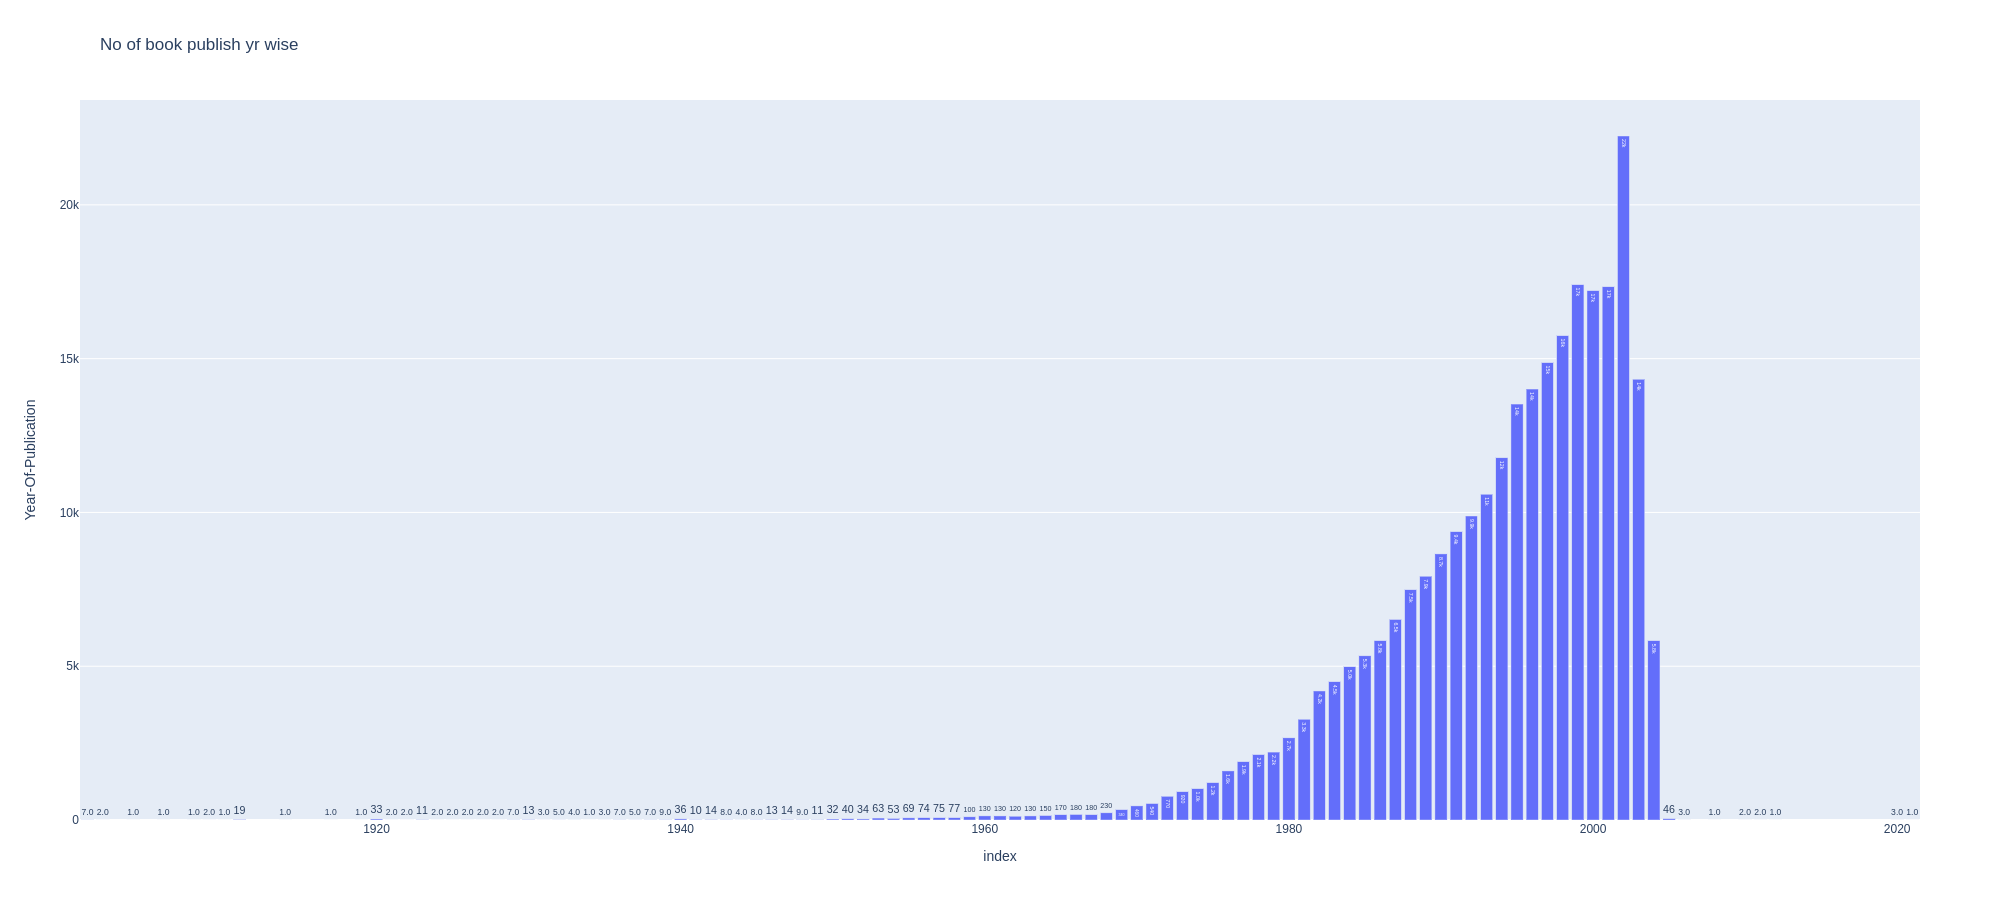

In [106]:
# Here we plot no of book publish yr wise here we not taken the old book in count 
import plotly.express as px
fig = px.bar(y, x='index', y='Year-Of-Publication',text_auto='.2s',title='No of book publish yr wise')
fig.show() 
# fig.show(renderer="png",width=2000, height=900)


**It show that the highest listed books publish on yr of 2002 is 22.39k.**

**Here we se that among the listed book more book are in between 1970 to 2004.**



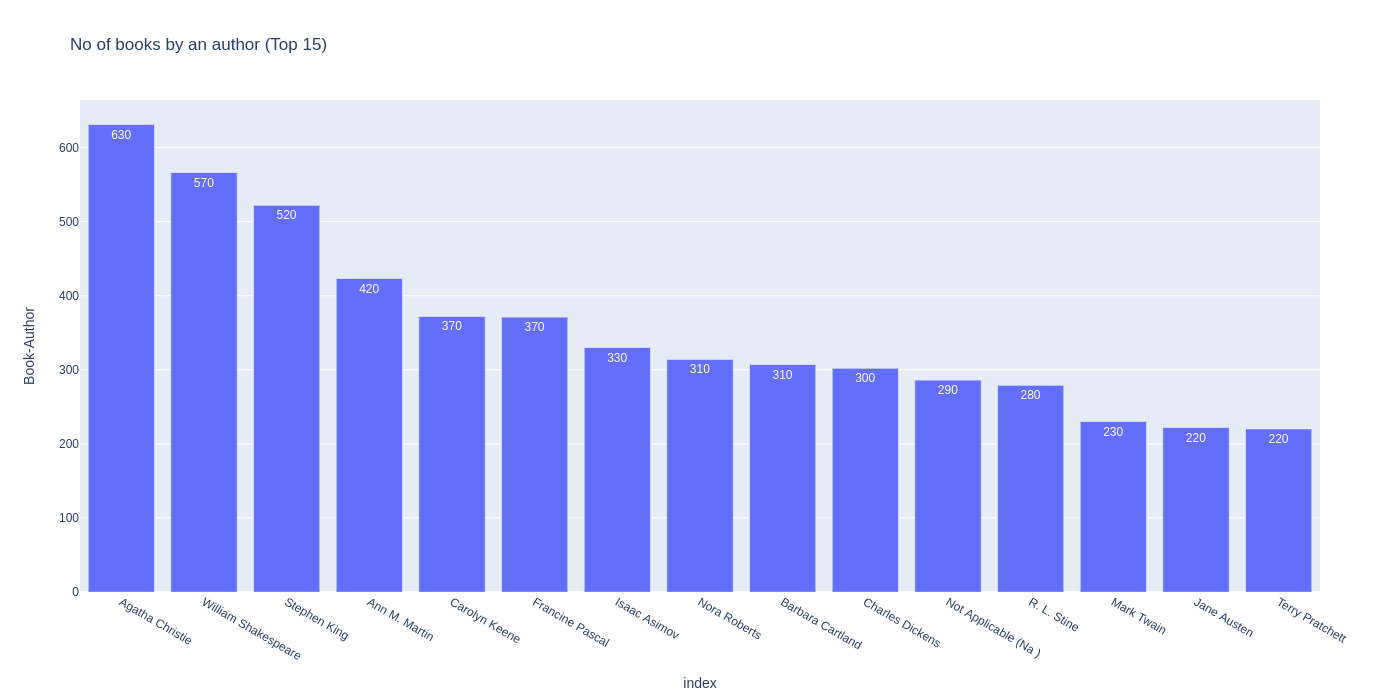

In [109]:
x=pd.DataFrame(books['Book-Author'].value_counts()[:15])
x
fig = px.bar(x, y='Book-Author', x=x.index, text_auto='.2s',
            title="No of books by an author (Top 15)")
# fig.show()
fig.show(renderer="png",width=1400, height=700)


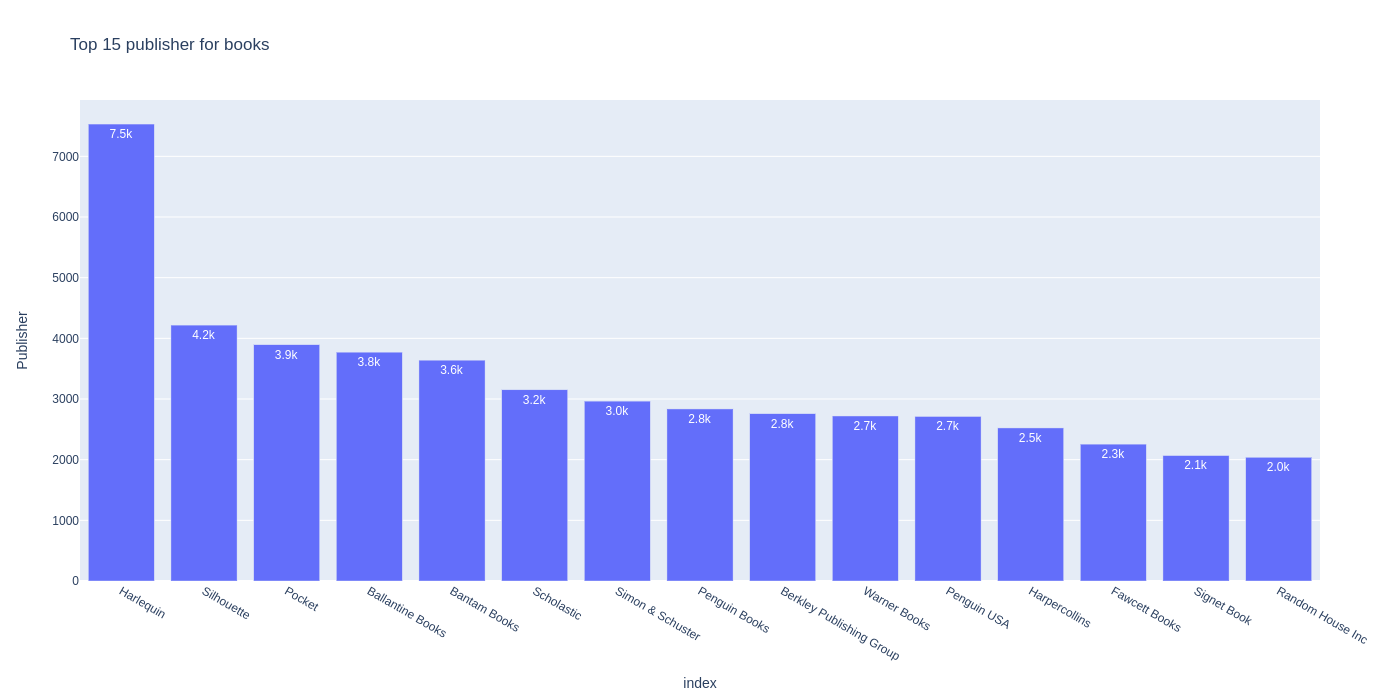

In [123]:
z=books['Publisher'].value_counts()[:15]
fig = px.bar(z, y='Publisher', x=z.index, text_auto='.2s',
            title="Top 15 publisher for books")
# fig.show()
fig.show(renderer="png",width=1400, height=700)

**Here we se that Harlequin publicatation publish most no of book its almost double than Silhouette which is in 2nd place.**


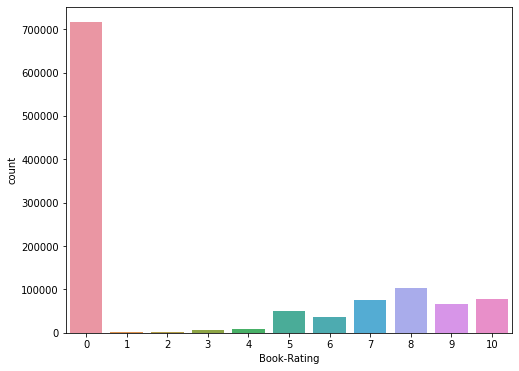

In [58]:
plt.figure(figsize=(8,6))
sns.countplot(x="Book-Rating", data=ratings)

**If we se the rating part most of not given any review here we consider 0.**

**It almost  50 to 60 percent of our dataset.**  

Text(0.5, 1.0, 'Explicit Ratings')

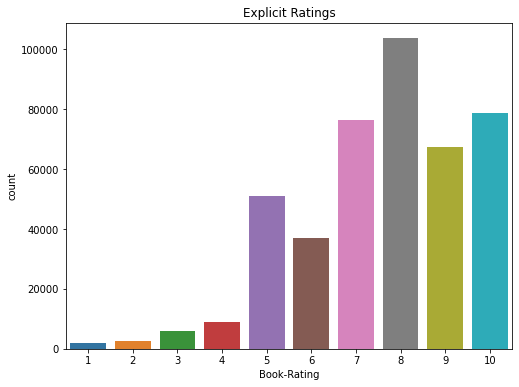

In [59]:
## Explicit Ratings
plt.figure(figsize=(8,6))
data = ratings[ratings['Book-Rating'] != 0]
sns.countplot(x="Book-Rating", data=data)
plt.title("Explicit Ratings")

**If we not consider 0 rating user we se highest no of user given rating 8.**\

**Almost eqal rating given to 7 and 10 then 9.**

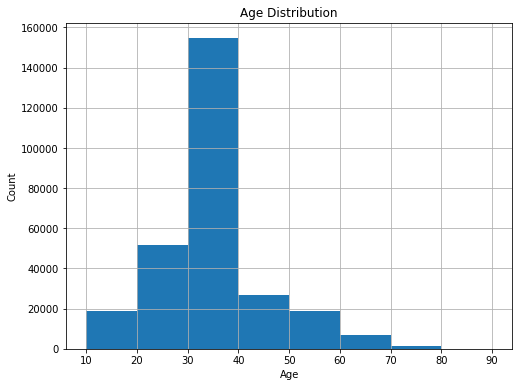

In [60]:
plt.figure(figsize=(8,6))
users.Age.hist(bins=[10*i for i in range(1, 10)])     
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

**Most of the user who rated the mv are from 30-40 yrs age then in 2nd its less than half of that catagory is 20-30.**

Text(0.5, 1.0, 'No of readers from each country (Top 10)')

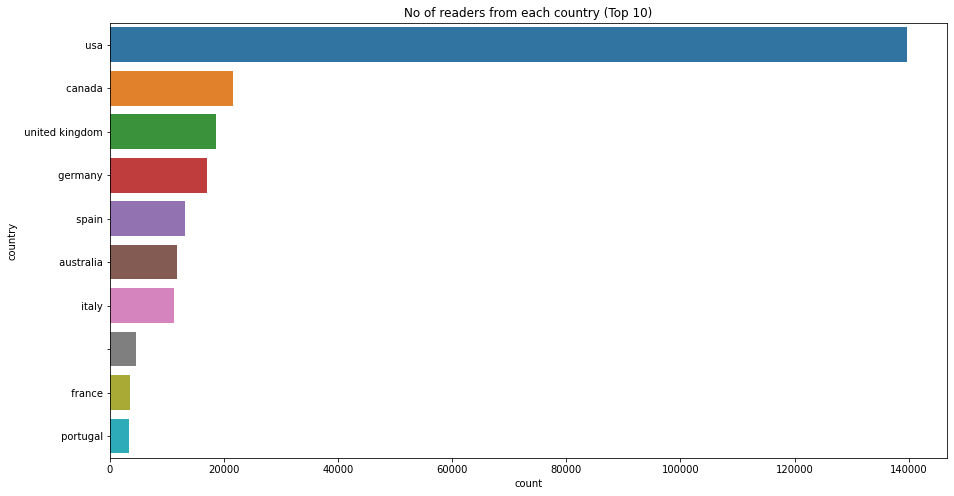

In [61]:
plt.figure(figsize=(15,8))
sns.countplot(y="country", data=users, order=users['country'].value_counts().index[0:10])
plt.title("No of readers from each country (Top 10)")

**Most of the book listed in our daaset are from usa its  cover almost 60 to70% of our data** 

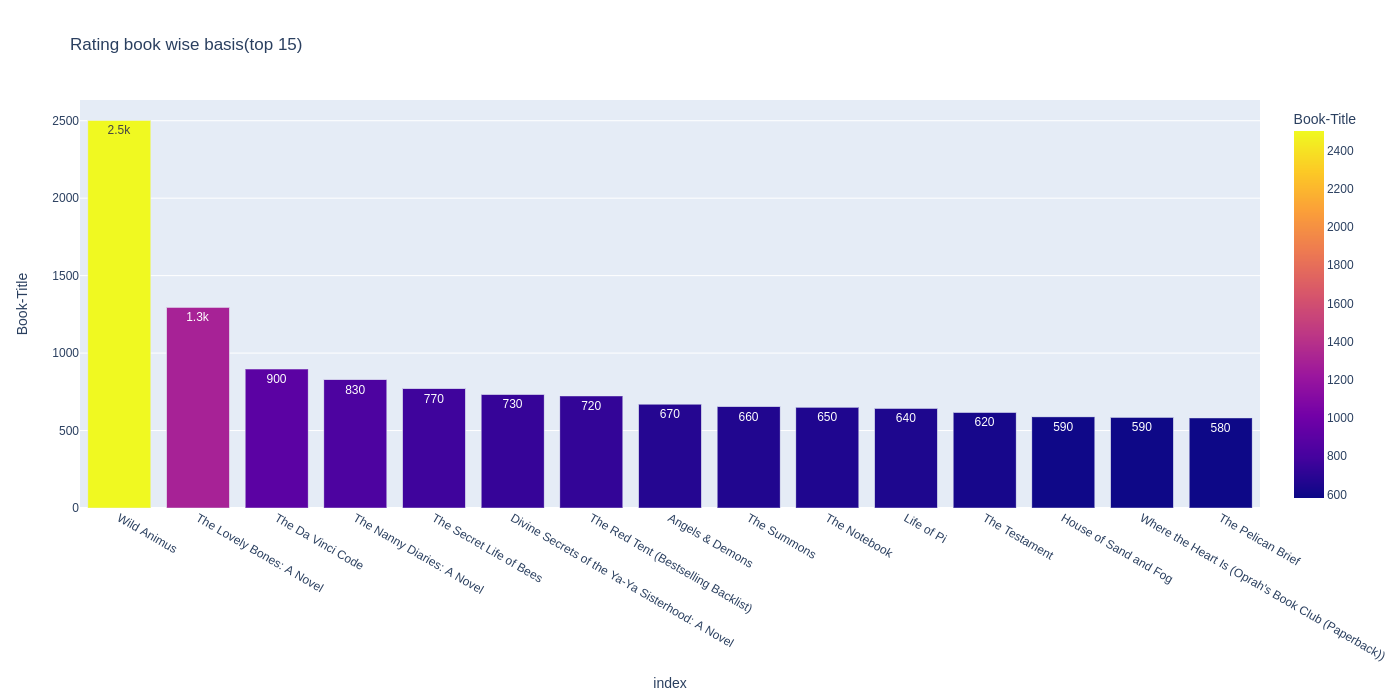

In [129]:
 
x=pd.DataFrame(dataset['Book-Title'].value_counts()[0:15])
x
fig = px.bar(x, y='Book-Title', x=x.index, text_auto='.2s',color ='Book-Title',
            title="Rating book wise basis(top 15)")
# fig.show()
fig.show(renderer="png",width=1400, height=700)

**In book Wild Animus user gives a high no of rating  which is 2.5k.**

**In 2nd place The Lovely Bones:A Novel book with rating of 1.3k.**

**Except these 2 books all other books are rating in between 580 to 900.**